#W207.5 Group Project

##Nate Black, Vineet Gangwar, Jared Maslin, Malini Mittal

##Kaggle Competition - "Forest Cover Type Prediction"

##MIDS Summer 2015 Term
----

###Section 1: Description of Kaggle Competition (with background and goal)

####Competition Description: Summary and Objective

This competition seeks to predict the forest cover type from strictly cartographic variables. The actual forest cover type for a given 30m x 30m patch was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

The dataset was provided by Jock A. Blackard and Colorado State University, and is hosted by UCI machine learning repository.

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. The goal is to predict an integer classification for the forest cover type. 

><strong>Tree Types</strong>  
<em>Spruce/Fir</em>   
<em>Lodgepole Pine</em>   
<em>Ponderosa Pine</em>  
<em>Cottonwood/Willow</em>   
<em>Aspen</em>
<em>Douglas-fir</em>   
<em>Krummholz</em>  

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features.

><strong>Data Fields</strong>  
<em>Elevation</em> - Elevation (in meters)  
<em>Aspect</em> - Aspect (in degrees azimuth)  
<em>Slope</em> - Slope (in degrees)  
<em>Horizontal_Distance_To_Hydrology</em> - Horizontal distance to nearest surface water features  
<em>Vertical_Distance_To_Hydrology</em> - Vertical distance to nearest surface water features  
<em>Horizontal_Distance_To_Roadways</em> - Horizontal distance to nearest roadway  
<em>Hillshade_9am (0 to 255 index)</em> - Hillshade index at 9am, summer solstice  
<em>Hillshade_Noon (0 to 255 index)</em> - Hillshade index at noon, summer solstice  
<em>Hillshade_3pm (0 to 255 index)</em> - Hillshade index at 3pm, summer solstice  
<em>Horizontal_Distance_To_Fire_Points</em> - Horizontal distance to nearest wildfire ignition points  
<em>Wilderness_Area</em> (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation  
<em>Soil_Type</em> (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation  
<em>Cover_Type</em> (7 types, integers 1 to 7) - Forest Cover Type Label

----

###Section 2: Data Loading and Exploration

Load the required libraries.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import csv
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
from math import sqrt
from time import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
plot_data = pd.read_csv('train.csv')

#Map tree codes to names
tree_map = {1:'Spruce/Fir',
            2:'Lodgepole Pine',
            3:'Ponderosa Pine',
            4:'Cottonwood/Willow',
            5:'Aspen',
            6:'Douglas-fir',
            7:'Krummholz'}

plot_data['Tree'] = plot_data['Cover_Type'].apply(func = lambda x: tree_map[x])

We saw that the data was evenly distributed across classes in the training data. This is important as we inferred that the test data does <em>not</em> show a similar distribution.

In [4]:
gb = plot_data.groupby(['Tree'])
gb['Id'].count()

Tree
Aspen                2160
Cottonwood/Willow    2160
Douglas-fir          2160
Krummholz            2160
Lodgepole Pine       2160
Ponderosa Pine       2160
Spruce/Fir           2160
Name: Id, dtype: int64

Before looking at algorithms, we plotted variables to explore the data.

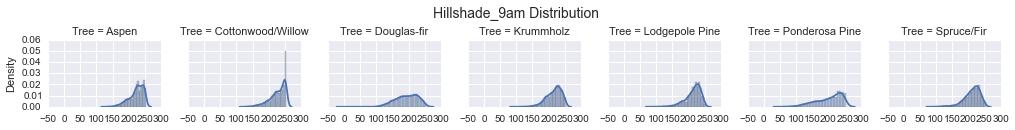

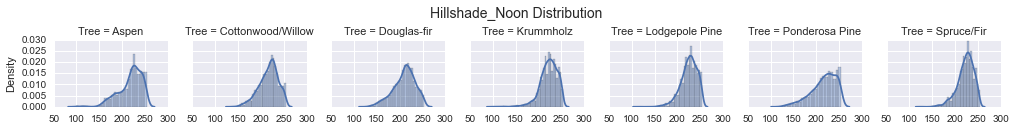

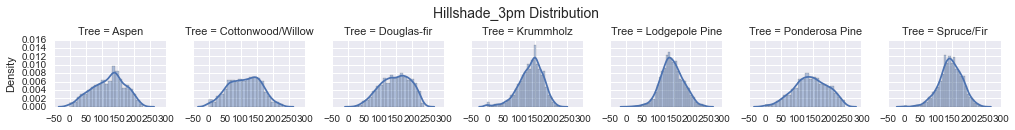

In [5]:
ordinal_columns = ['Hillshade_9am', 
                'Hillshade_Noon', 
                'Hillshade_3pm']

def ord_dist(var):
    items = sns.FacetGrid(plot_data, col = 'Tree', size= 2)
    items.map(sns.distplot, var).set_axis_labels('','Density')
    items.fig.suptitle(var + " Distribution", size = 14)
    plt.subplots_adjust(top=0.75)
    plt.show()

for col in ordinal_columns:
    ord_dist(col)

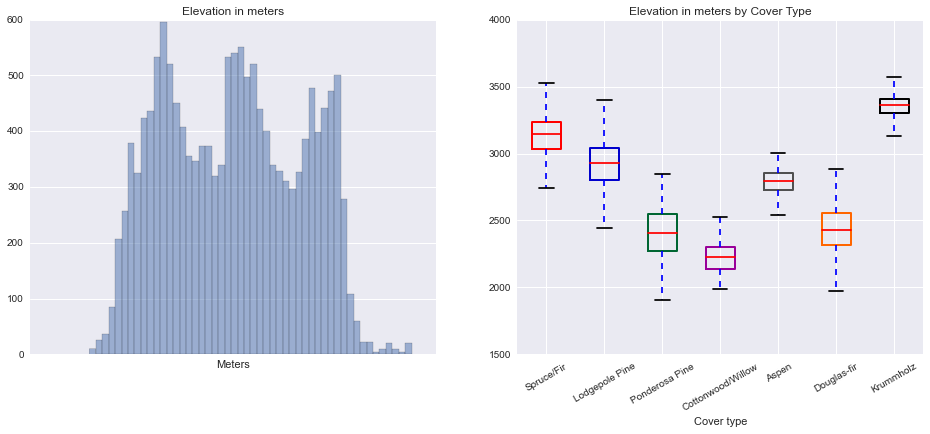

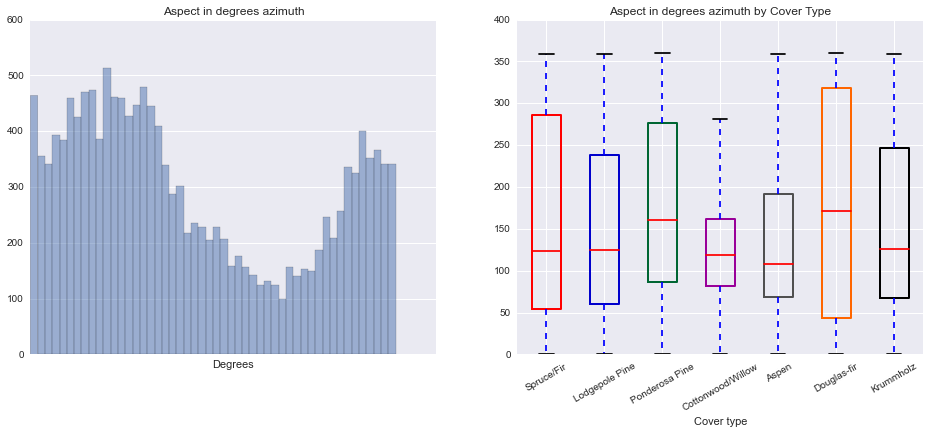

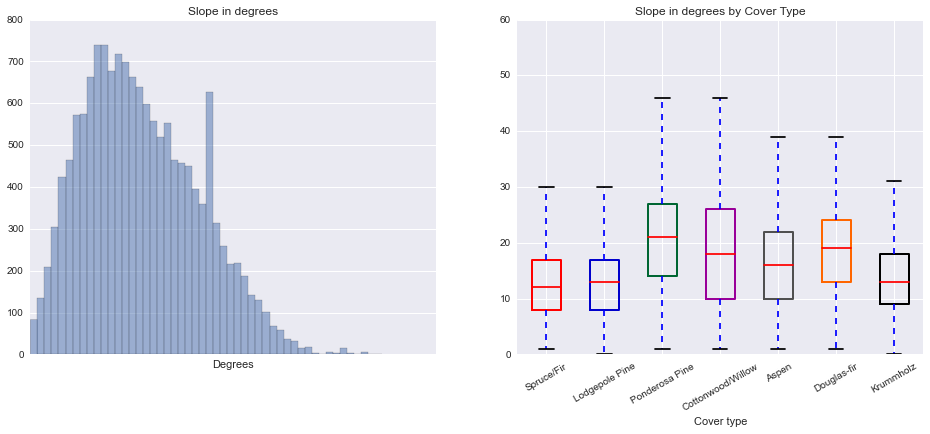

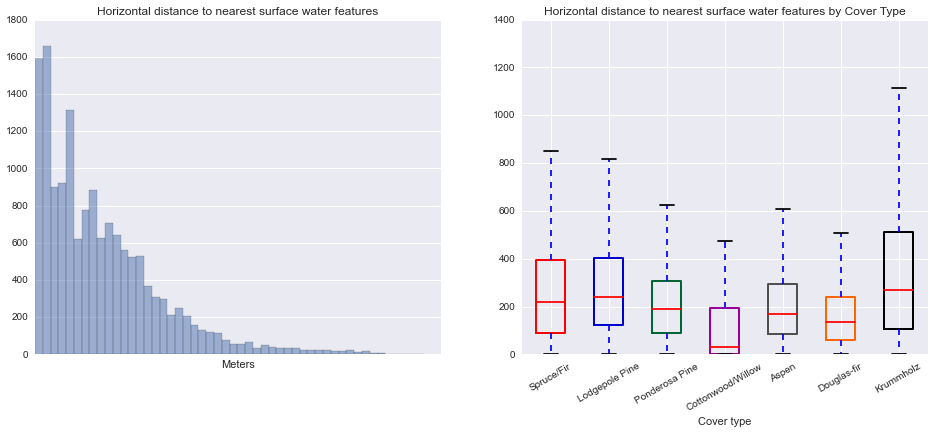

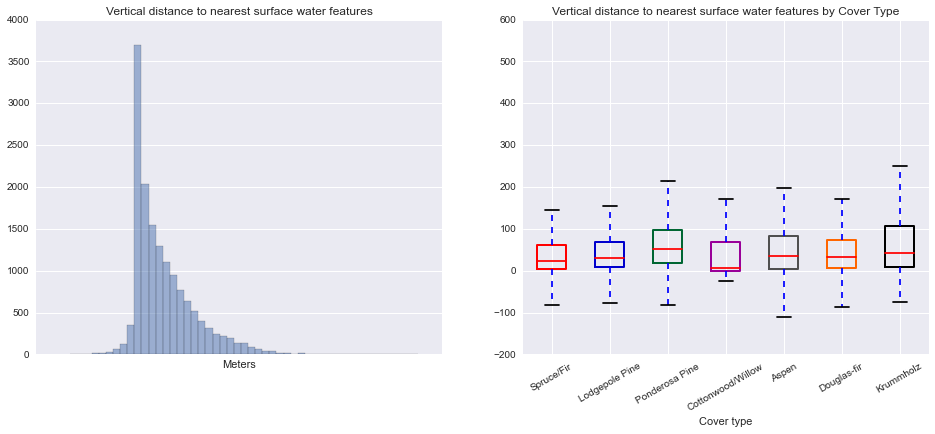

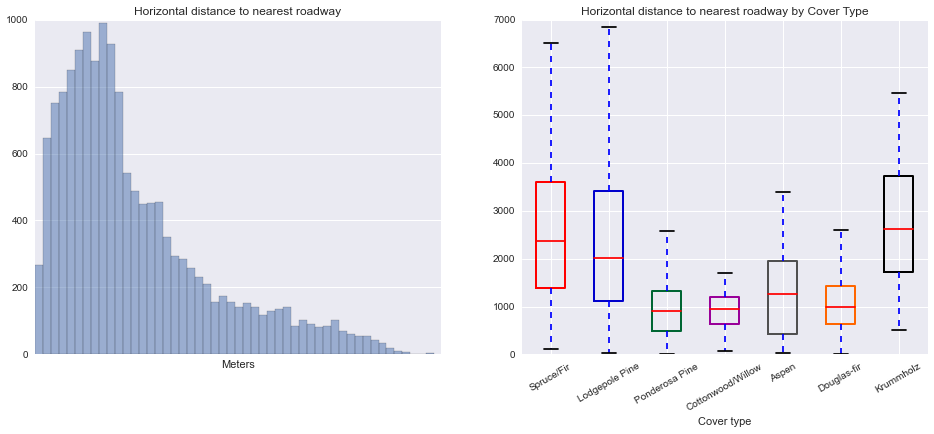

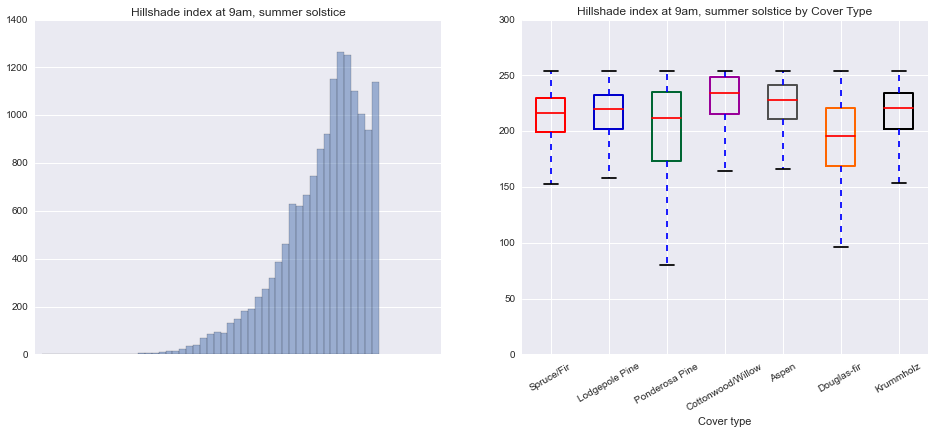

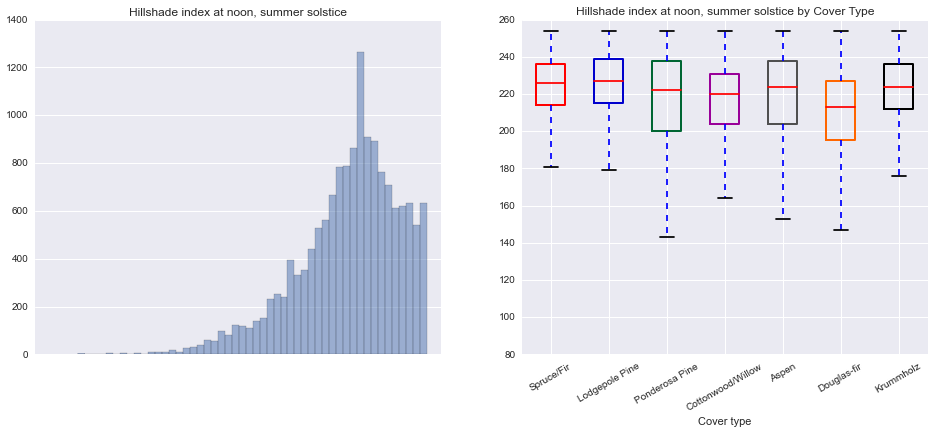

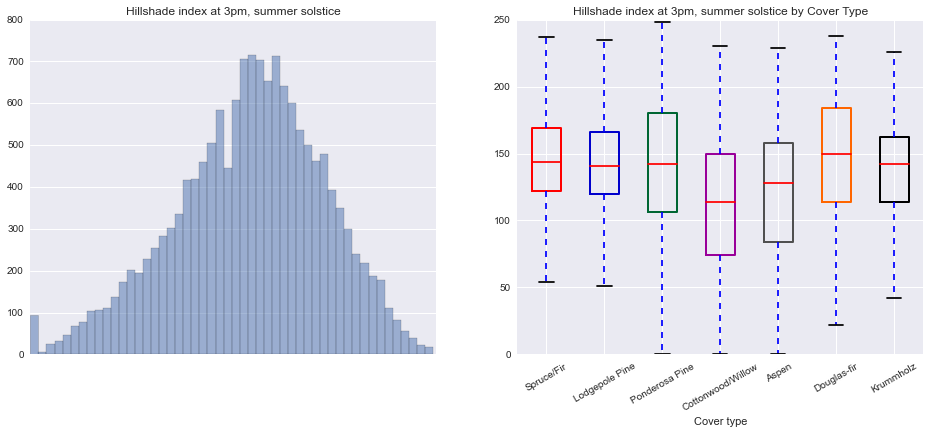

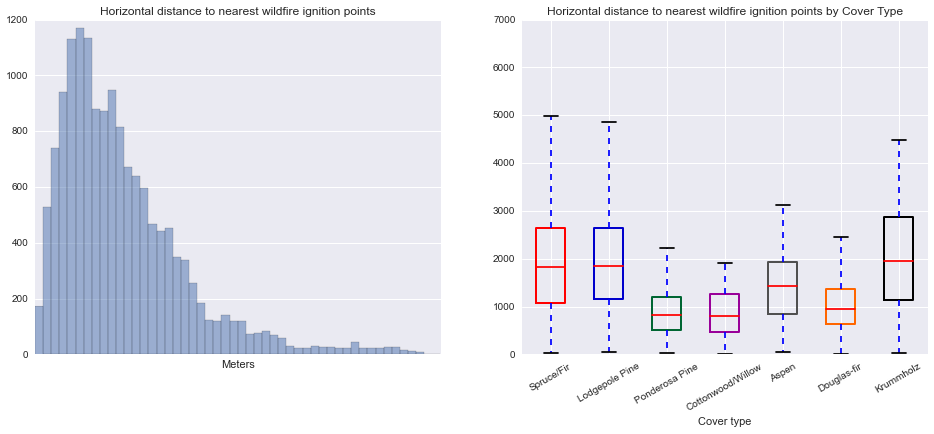

In [6]:
# Visualizing data distributions - Plotting histograms
cover_type = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
              'Cottonwood/Willow','Aspen', 'Douglas-fir', 'Krummholz']

#Grab some colors for plotting
colors = ["#FF0000", "#0000CC", "#006633", "#990099", "#505050", "#FF6600", "#000000"]

def plot_histogram(ax, data, title, xlab):
    ax.hist(data, bins=50, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_xticks([])
    
def plot_class_wise_data(ax, data, title, labels):
    boxplotdata = list()
    for classes in range(1, 8):
        sub_data = data[np.where(labels == classes)]
        boxplotdata.append(sub_data)

    bp = ax.boxplot(boxplotdata)
    ax.set_xlabel('Cover type')
    ax.set_title(title + ' by Cover Type')
    ax.set_xticklabels(cover_type, rotation=30)

    for i, box in enumerate(bp['boxes']):
        box.set(color=colors[i], linewidth=2)

def plotter(data, labels, title_1, x_label_1):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    plot_histogram(ax1, data, title_1, x_label_1)
    ax2 = fig.add_subplot(1, 2, 2)
    plot_class_wise_data(ax2, data, title_1, labels)

#Define titles, labels, and variables
titles = ['Elevation in meters', 'Aspect in degrees azimuth', 'Slope in degrees',
          'Horizontal distance to nearest surface water features', 
          'Vertical distance to nearest surface water features',
          'Horizontal distance to nearest roadway', 'Hillshade index at 9am, summer solstice',
          'Hillshade index at noon, summer solstice','Hillshade index at 3pm, summer solstice',
          'Horizontal distance to nearest wildfire ignition points']

labels = ['Meters', 'Degrees', 'Degrees', 'Meters', 'Meters', 'Meters', '', '', '', 'Meters']

variables = [plot_data.Elevation, plot_data.Aspect, plot_data.Slope, plot_data.Horizontal_Distance_To_Hydrology,
             plot_data.Vertical_Distance_To_Hydrology, plot_data.Horizontal_Distance_To_Roadways,
             plot_data.Hillshade_9am, plot_data.Hillshade_Noon, plot_data.Hillshade_3pm,
             plot_data.Horizontal_Distance_To_Fire_Points]

#Plot distribution and boxplots
for var, title, label in zip(variables, titles, labels):
    plotter(var.values, plot_data.Cover_Type.values, title, label)

From the graphs above, we see that elevation shows a clear distinction across classes and may be an important variable. We can also see separation in the slope, distance to roadway, and distance to wildfire variables.

In [7]:
wilderness_area_names = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']

fig = plt.figure(figsize=(16, 6))

# Wilderness_Area
wilderness_areas = np.sum(train_data[:,10:14], axis=0)
ax = fig.add_subplot(1, 2, 1)
dummy = ax.bar(np.arange(4), wilderness_areas, alpha=0.5)
dummy = ax.set_title("Wilderness area designation")
dummy = ax.set_xlabel('Wilderness areas')

# Wilderness_Area per cover type
ax = fig.add_subplot(1, 2, 2)

ind = np.arange(4)
width = 0.1
for i in range(1, 8):
    wilderness_areas = np.sum(train_data[np.where(train_labels==i),10:14][0], axis=0)
    bar = ax.bar(ind, wilderness_areas, width=width, color=random_colors[i-1,:])
    ind = ind + width
    dummy = ax.set_title("Wilderness area designation")
    dummy = ax.set_xlabel('Wilderness areas')
    ax.legend(cover_type)
dummy = ax.set_xlim(0, 4)
bar = ax.bar(np.arange(4), [2500, 2500, 2500, 2500], width=(width*7), color='black', alpha=0.1)

NameError: name 'train_data' is not defined

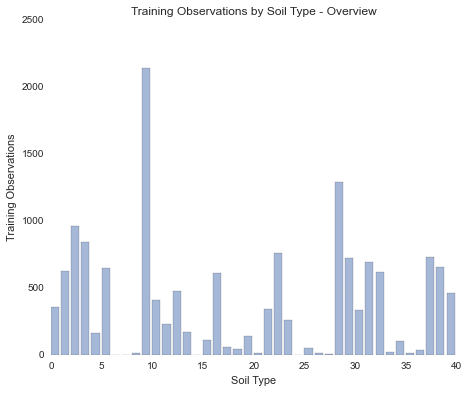

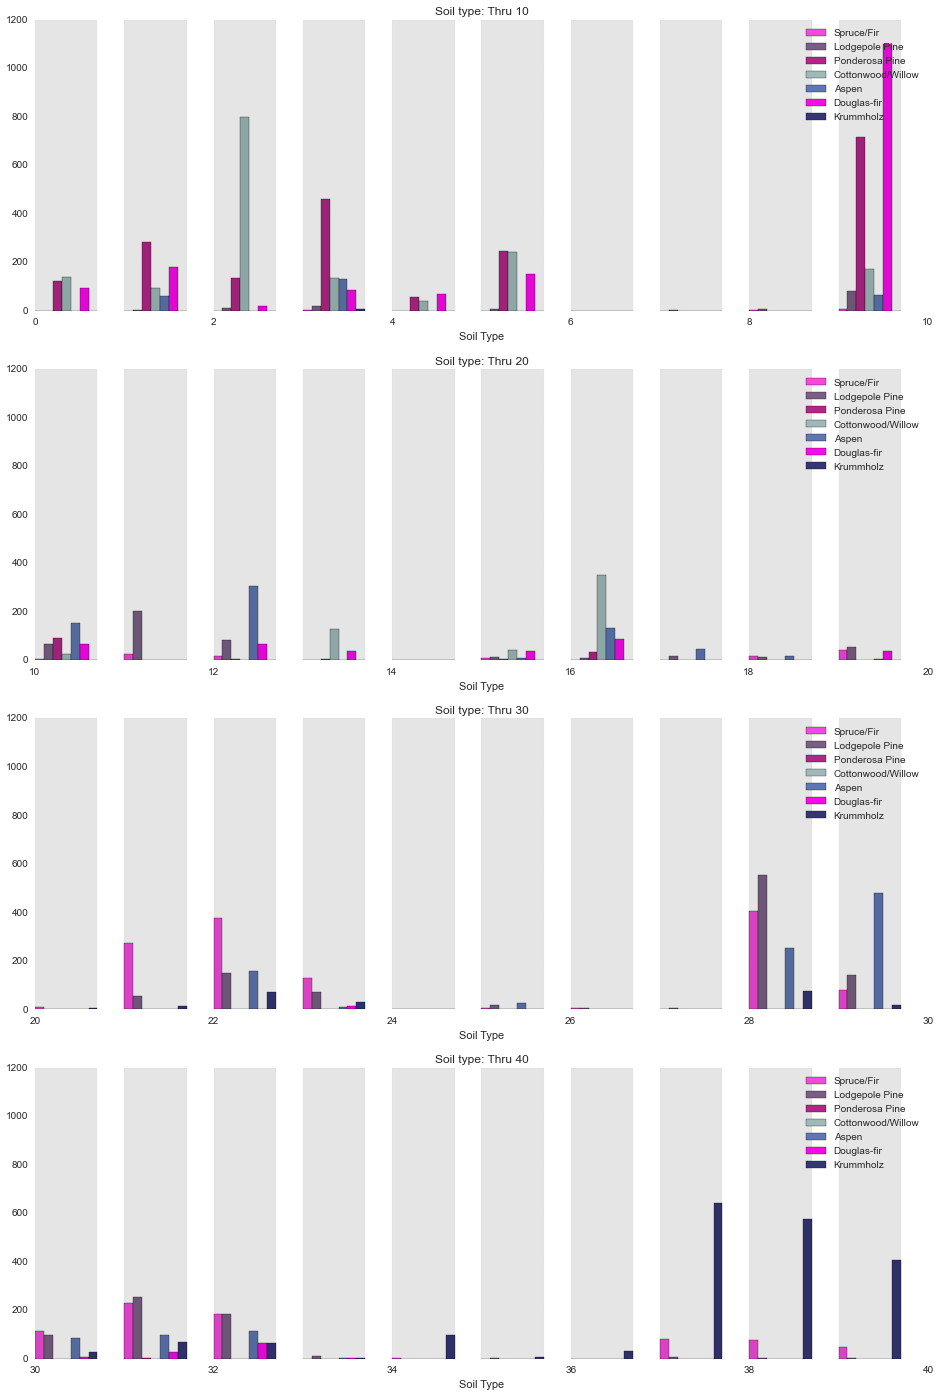

In [22]:
# Soil_Type
fig = plt.figure(figsize=(16, 6))
soil_type = np.sum(train_data[:,14:55], axis=0)
ax = fig.add_subplot(1, 2, 1)
dummy = ax.bar(np.arange(40), soil_type, alpha=0.5)
dummy = ax.set_title("Training Observations by Soil Type - Overview")
dummy = ax.set_xlabel('Soil Type')
dummy = ax.set_ylabel('Training Observations')

# Soil type per cover type
fig = plt.figure(figsize=(16, 24))

for j in range(4):
    ax = fig.add_subplot(4, 1, j+1)
    dummy = ax.set_title("Training Observations by Soil Type - Detailed")
    ind = np.arange(10*j, 10*j+10)
    width = 0.1
    for i in range(1, 8):
        soil_type = np.sum(train_data[np.where(train_labels==i),((j+1)*10)+4:((j+1)*10)+14][0], axis=0)
        bar = ax.bar(ind, soil_type, width=width, color=random_colors[i-1,:])
        ind = ind + width
        title = "Soil type: Thru " + str((j+1) * 10)
        dummy = ax.set_title(title)
        dummy = ax.set_xlabel('Soil Type')
        ax.legend(cover_type)
    bar = ax.bar(np.arange(10*j, 10*j+10), [1200]*10, width=(width*7), color='black', alpha=0.1)

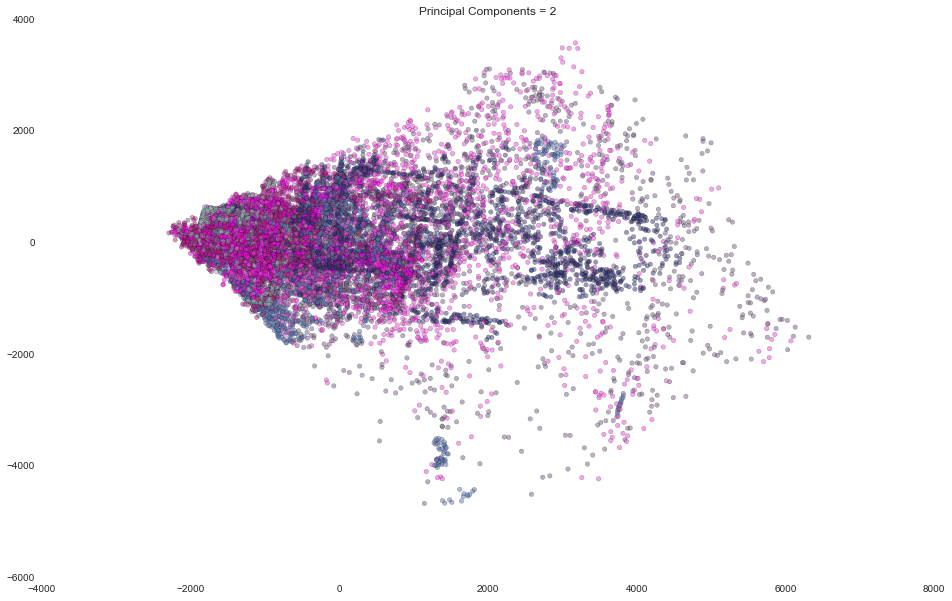

In [23]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(train_data)

colors = np.zeros((train_data.shape[0], 3))
for i in range(colors.shape[0]):
    colors[i,] = random_colors[train_labels[i]-1]

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)
dummy = ax.scatter(transformed_data[:,0], transformed_data[:,1], c=colors, alpha=0.5)
dummy = ax.set_title("Principal Components = 2")

----

###Section 3: Creating a Baseline Model for Kaggle  

Establish a baseline score in Kaggle using basic KNN model where K = 1

In [8]:
#Load the training data
full_train_data = pd.read_csv('train.csv', header=0) 
full_train_labels = full_train_data['Cover_Type']
full_train_id = full_train_data['Id']
full_train_data.drop(['Cover_Type', 'Id'], axis=1, inplace=True) 

#Load the test data
full_test_data = pd.read_csv('test.csv', header=0) 
full_test_id = full_test_data['Id']
full_test_data.drop(['Id'], axis=1, inplace=True) 

#Fit KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(full_train_data.values, full_train_labels.values)

#Create Predictions and export to CSV
predictions = knn.predict(full_test_data).astype(int) 
submission = pd.DataFrame(full_test_id, columns = ['Id'])
submission['Cover_Type'] = predictions
submission.to_csv("sampleSubmissionKNN1.csv", index = False, index_col = False)

<strong>This baseline yields a Kaggle score of 0.71016 (leaderboard rank = 1175)</strong>  

----
###Section 4: Run baseline models for comparison
To do this, we will need to create a development (validation) set out of the training data provided. This splitting will allow for us to test several classifiers at a high level before selecting the most insightful classifier for further definition.   

In [9]:
#Shuffle the data
X = full_train_data.values
Y = full_train_labels.values
shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

#Split the data into training and development sets
train_data, dev_data, train_labels, dev_labels = train_test_split(X, Y, test_size=0.1, random_state=0)

In [12]:
#Baseline K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)
print 'K-Nearest Neighbors yields an accuracy of %.2f%%' % (knn.score(dev_data, dev_labels)*100)

#Baseline Linear Regression
lr = LinearRegression() 
lr.fit(train_data, train_labels)
print '\nLinear Regression yields an accuracy of %.2f%%' % (lr.score(dev_data, dev_labels)*100)

#Baseline Logistic Regression
lm = LogisticRegression() 
lm.fit(train_data, train_labels)
print '\nLogistic Regression yields an accuracy of %.2f%%' % (lm.score(dev_data, dev_labels)*100)

#Baseline Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(train_data, train_labels)
print '\nGaussian Naive Bayes yields an accuracy of %.2f%%' % (gnb.score(dev_data, dev_labels)*100)

#Baseline Random Forest
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)
print '\nRandom Forest yields an accuracy of %.2f%%' % (rf.score(dev_data, dev_labels)*100)

#Baseline "ExtraTrees"
et = ExtraTreesClassifier()
et.fit(train_data, train_labels)
print '\nExtra Trees yields an accuracy of %.2f%%' % (et.score(dev_data, dev_labels)*100)

K-Nearest Neighbors yields an accuracy of 81.15%

Linear Regression yields an accuracy of 43.07%

Logistic Regression yields an accuracy of 66.60%

Gaussian Naive Bayes yields an accuracy of 46.96%

Random Forest yields an accuracy of 83.13%

Extra Trees yields an accuracy of 83.86%


One surprise that pops out is the relative accuracy for KNN model (where K = 1) with respect to regressions and Naive Bayes. That said, both Random Forest and Extra Trees produce slightly superior results. 

With this initial validation complete, we will move forward with further developing a model based on the Extra Trees classifier. Random Forest/Extra Trees seem appropriate as there appear to be breakpoints in some of the variables and a decision tree seems apt to find these breakpoints.

In [10]:
#Establish a new baseline with Kaggle using the basic Extra Trees Classifier
et = ExtraTreesClassifier()
et.fit(train_data, train_labels)

#Predict on the test data
predictions = et.predict(full_test_data).astype(int) 
submission = pd.DataFrame(full_test_id, columns = ['Id'])
submission['Cover_Type'] = predictions
submission.to_csv("sampleSubmissionET1.csv", index = False, index_col = False)

<strong>This new baseline (using the Extra Trees classifier) yields a Kaggle score of 0.71962 (leaderboard rank = 1117)</strong>

To determine where the model is misclassifying, the confusion matrix is analyzed.

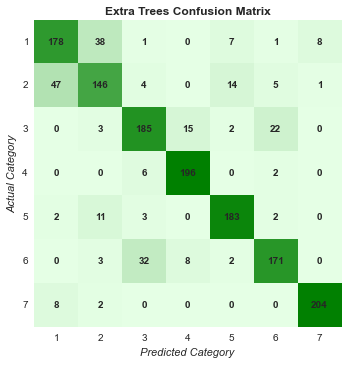

In [13]:
#See where the model is making errors
predictions_dev = et.predict(dev_data).astype(int) 
cf = confusion_matrix(dev_labels, predictions_dev)
conf_arr = cf.tolist()
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        if a == 0:
            tmp_arr.append(0)
        else:
            tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
cmap = sns.light_palette('green', as_cmap = True)
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=cmap, 
                interpolation='nearest')

width = len(conf_arr)
height = len(conf_arr[0])

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
plt.title('Extra Trees Confusion Matrix',weight='bold')
plt.ylabel('Actual Category', style='italic')
plt.xlabel('Predicted Category',style='italic')
items = [1,2,3,4,5,6,7]
plt.xticks(range(width), items)
plt.yticks(range(height), items)
plt.grid(b = None)

We see the classifier is performing well across most classes but is having difficult distinguishing the first and second classes. 

----
###Section 5: Feature Engineering and Parameter/Model Tuning

Parameter Tuning -- Attack the skew!

Something that we've seen in our error analysis throughout this exercise is that while the training data possesses an even split of observations between the seven cover_types, the test dataset possesses an overwhelming percentage of cover_types (1 and 2), over cover_type (3 thru 7). This was inferred by our relatively high Kaggle score and the distribution of our predictions. I.e. We predicted mostly 1 and 2 and received a score of ~70%.

To address this, we can attempt to de-skew the data by searching for target weights amongst the cover_types. By using a simple classifier (like KNN) and running for a few iterations in order to estimate feature weights across each run, we may be able to form a more generalizable expectation of cover_type distribution.

In [20]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_data, train_labels)

#create a zero array to hold target weights
weights = np.zeros(7)
test_todense = test_data.values

#iterate 5 times:
#extract a random subset of test data
#predict the KNN target value
#add the target weights to the weights array
for i in range(5):
    test_subset = test_todense[np.random.choice(test_todense.shape[0],10000)] #get a random 10000 example subset
    weights = weights + np.bincount(knn.predict(test_subset))[1:]
    
#create a target weights dictionary with the average predicted weights
weights = weights / 5.0 #average weights
weight_dict = {i+1:weights[i]/np.sum(weights) for i in range(len(weights))} #dictionary of normalized average weights

print "Class Weights to Account for Skew"
print "=" * 35
for cls, wt in weight_dict.items():
    print "Class: %d\tWeight: %.2f%%" % (cls, wt * 100)

del test_todense

#With this code in place, we can add the attribute "class_weight=weight_dict" within our ExtraTreesClassifier

Class Weights to Account for Skew
Class: 1	Weight: 35.93%
Class: 2	Weight: 38.50%
Class: 3	Weight: 7.14%
Class: 4	Weight: 0.52%
Class: 5	Weight: 6.59%
Class: 6	Weight: 4.66%
Class: 7	Weight: 6.66%


----

The following sections briefly describe features that were derived and the rationale behind each feature.  

<strong>Feature Engineering - Sunlight/Energy received by a 30 by 30 patch </strong>  

The idea behind this feature is that different trees respond differently to different amounts of sunlight/energy.

The dataset provides values of Hillshade for every patch at 9 am, 12 noon and 3 pm. Hillshade is a measure of sunlight incident upon a patch. It has values between 0 and 255 where 0 represents absence of sunlight. Hillshade takes into account Sun's elevation, latitude, slope and aspect of the patch.

This engineered feature indicates the relative amount of sunlight/energy a patch receives. The assumption is that amount of sunlight is more directly correlated to Cover_Type than individual measures of Hillshade and hence is a better predictor. The amount of sunlight is calculated as area under the curve of the below figure.

This figure below is a simplification of the curve because it is not a linear function. But despite the simplification we get an increase in accuracy.

To calculate the area, we measured time in seconds, which is shown below as 10,800 seconds (amount of seconds in a 3-hour period).

After calculating the energy feature, we drop the original hillshade features.

\begin{equation}
\begin{split}
Energy &= \left(\frac{Hillshade9AM + Hillshade12PM}{2} \cdot 10,800\right) + \left(\frac{Hillshade12PM + Hillshade3PM}{2} \cdot 10,800\right)
\end{split}
\end{equation}

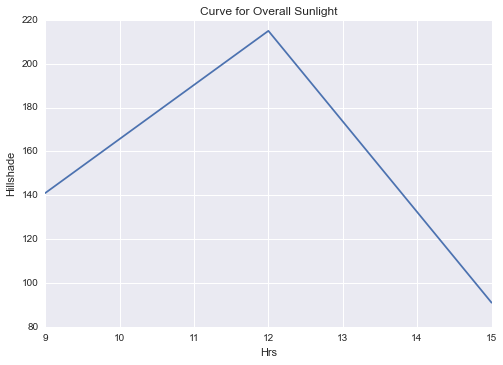

In [51]:
#Load the training data
train_data = pd.read_csv('train.csv', header=0) 
test_data = pd.read_csv('test.csv', header=0) 

plt.figure() 
hillshade = [141, 215, 91]        # Hillshade values at 9 am, 12 noon and 3 pm
time = [9, 12, 15]                # Time at 9 am, 12 noon and 3 pm
plt.plot([9, 12, 15], [141, 215, 91])
plt.xlabel('Hrs')
plt.ylabel('Hillshade')
plt.title('Curve for Overall Sunlight');

<strong>Feature Engineering/Preprocessing - Scrubbing the Hillshade_3pm values of 0</strong>

In plotting the Hillshade values against one another, we see that "Hillshade_3pm" actually includes a group of zeroes in the dataset. As this is not the case with either of the other Hillshade features, we may find that this batch of zeroes can skew our data unknowingly.

To address this concern, let's fill in the zero-value observations for Hillshade_3pm with the overall median of the non-zero Hillshade_3pm values.

##**IS THIS USED IN FINAL CALC?

In [ ]:

temp = train_data.copy()
cols = temp.columns.tolist()
cols = cols[:8]+ cols[9:] + [cols[8]]
temp = temp[cols]
del temp['Cover_Type']


X, y, X_train_data_missing, y_train_data_missing = temp[temp.Hillshade_3pm!=0].values[:,:-1],temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),temp[temp.Hillshade_3pm==0].values[:,:-1],temp[temp.Hillshade_3pm==0].values[:,-1:].ravel()


X_train, X_test, y_train, y_test = train_test_split(X,y)
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp.fit(X_train,y_train)
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_train_data_missing)
train_data.Hillshade_3pm=temp.Hillshade_3pm


temp=test.copy()
cols=temp.columns.tolist()
cols=cols[:8] + cols[9:] + [cols[8]]
temp=temp[cols]


X_test_data_missing = temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0] = imp.transform(X_test_data_missing)
test_data.Hillshade_3pm = temp.Hillshade_3pm

<strong>Feature Engineering - Is patch closer to Roadway and Firepoint than water </strong>

The idea behind these features is that hydrology affect on trees wil be impacted if human effects (Roadways) and natural hazards (fires) are nearby.
These features indicate if roadways and fire points are closer to a patch than hydrology.
These features have improved accuracy and made intuitive sense.

<strong>Feature Engineering - Above Sea Level </strong>

This simple transformation indicates if a tree is above or below sea level.

<strong>Feature Engineering - Vertical to Water</strong>

This transformation combines elevation and the vertical distance to water features. The rationale is that impact of vertical distance to water changes relative to the elevation.

<strong>Feature Engineering - Horizontal to Water</strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Pythagorean to Water</strong>

This transformation combines horizontal and vertical water distances using the Pythagorean theorem. It triangulates the nearest water supply. This could be important in cases where vertical and horizontal distances to water are very different and looking at the individual features would not pick this up.

<strong>Feature Engineering - Water and Fire </strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Water Less Fire</strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Water and Roadway </strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Water Less Roadway/strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Fire and Roadway/strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Fire Less Roadway/strong>

##**PLEASE EXPLAIN RATIONALE

<strong>Feature Engineering - Creating features to differentiate Cover_Types 1 and 2 </strong>

The test data is unusual because it is heavily skewed towards Cover_Types 1 and 2. Additionally, train data shows that these two cover types are very similar.
Nate's bivariate distribution contour plot will demonstrate this point 
To induce variation in the data we have added two extra features by multiplying features together. Multiplication will amplify the variation.
These features have increased the accuracy

\begin{equation}
\begin{split}
ExtraFeature1 &=  Slope \cdot HorizontalDistanceToHydrology \cdot VerticalDistanceToHydrology \\
ExtraFeature2 &=  HorizontalDistanceToFire \cdot HorizontalDistanceToRoadways
\end{split}
\end{equation}

##**Bivariate dist not included above

<strong> Feature Engineering - Grouping like-terms for Soil Types </strong>

In plotting the 40 different soil types above (Data Exploration section), we saw that each type of tree is only represented in a handful of soil types. That is, only a portion of the soil types suit one type of tree versus another. In digging deeper (https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info), we find that the soil type (which is a four-digit ID) can be split into two sections. One section is an arbitrary ID code to aid the original data gatherers. The first two digits, though, represents a specific grouping of tree types based on the soil. 

With this in mind, we can map the original 40 soil types to actual 11 types.

In [ ]:
#Helper function to group soil types
def group_soil_types(*args):
    return np.where(np.sum(args, axis = 0) > 0, 1, 0)

def convert_soil_types(fr):
    #Soil types 1, 2, 3, 4, 5, and 6 are grouped together
    fr['new_soil_1'] = group_soil_types(fr['Soil_Type1'], fr['Soil_Type2'], fr['Soil_Type3'],
                       fr['Soil_Type4'],fr['Soil_Type5'],fr['Soil_Type6']) 
    
    #Soil types 7 & 8 are grouped together
    fr['new_soil_2'] = group_soil_types(fr['Soil_Type7'], fr['Soil_Type8'])
    
    #Soil type 9 is it's own group
    fr['new_soil_3'] = fr['Soil_Type9']
    
    #Soil types 10, 11, 12, 13
    fr['new_soil_4'] = group_soil_types(fr['Soil_Type10'], fr['Soil_Type11'], fr['Soil_Type12'], fr['Soil_Type13'])
    
    #Soil types 14 & 15 are grouped together
    fr['new_soil_5'] = group_soil_types(fr['Soil_Type14'], fr['Soil_Type15'])

    #Soil types 16 & 17 are grouped together
    fr['new_soil_6'] = group_soil_types(fr['Soil_Type16'], fr['Soil_Type17'])
    
    #Soil type 18 is it's own group
    fr['new_soil_7'] = fr['Soil_Type18']
    
    #Soil type 19, 20, & 21 are grouped
    fr['new_soil_8'] = group_soil_types(fr['Soil_Type19'], fr['Soil_Type20'], fr['Soil_Type21'])
    
    #Soil type 19, 20, & 21 are grouped
    fr['new_soil_9'] = group_soil_types(fr['Soil_Type22'], fr['Soil_Type23'])
    
    #Soil type 24-34 are grouped together
    fr['new_soil_10'] = group_soil_types(fr['Soil_Type24'], fr['Soil_Type25'],fr['Soil_Type26'], fr['Soil_Type27'], 
                                       fr['Soil_Type28'], fr['Soil_Type29'],fr['Soil_Type30'], fr['Soil_Type31'], 
                                       fr['Soil_Type32'], fr['Soil_Type33'],fr['Soil_Type34'])
    
    #Soil type 35-40 are grouped together
    fr['new_soil_11'] = group_soil_types(fr['Soil_Type35'], fr['Soil_Type36'],fr['Soil_Type37'], fr['Soil_Type38'], 
                                         fr['Soil_Type39'], fr['Soil_Type40'])
                                         
    return fr
# def convert_soil_types(fr):
#     new_soil_1 = np.zeros(fr.shape[0])
#     new_soil_2 = np.zeros(fr.shape[0])
#     new_soil_3 = np.zeros(fr.shape[0])
#     new_soil_4 = np.zeros(fr.shape[0])
#     new_soil_5 = np.zeros(fr.shape[0])
#     new_soil_6 = np.zeros(fr.shape[0])
#     new_soil_7 = np.zeros(fr.shape[0])
#     new_soil_8 = np.zeros(fr.shape[0])
#     new_soil_9 = np.zeros(fr.shape[0])
#     new_soil_10 = np.zeros(fr.shape[0])
#     new_soil_11 = np.zeros(fr.shape[0])

#     new_soil_1 = np.where(fr['Soil_Type1']==1, 1, new_soil_1)
#     new_soil_1 = np.where(fr['Soil_Type2']==1, 1, new_soil_1)
#     new_soil_1 = np.where(fr['Soil_Type3']==1, 1, new_soil_1)
#     new_soil_1 = np.where(fr['Soil_Type4']==1, 1, new_soil_1)
#     new_soil_1 = np.where(fr['Soil_Type5']==1, 1, new_soil_1)
#     new_soil_1 = np.where(fr['Soil_Type6']==1, 1, new_soil_1)

#     new_soil_2 = np.where(fr['Soil_Type7']==1, 1, new_soil_2)
#     new_soil_2 = np.where(fr['Soil_Type8']==1, 1, new_soil_2)

#     new_soil_3 = np.where(fr['Soil_Type9']==1, 1, new_soil_3)

#     new_soil_4 = np.where(fr['Soil_Type10']==1, 1, new_soil_4)
#     new_soil_4 = np.where(fr['Soil_Type11']==1, 1, new_soil_4)
#     new_soil_4 = np.where(fr['Soil_Type12']==1, 1, new_soil_4)
#     new_soil_4 = np.where(fr['Soil_Type13']==1, 1, new_soil_4)

#     new_soil_5 = np.where(fr['Soil_Type14']==1, 1, new_soil_5)
#     new_soil_5 = np.where(fr['Soil_Type15']==1, 1, new_soil_5)

#     new_soil_6 = np.where(fr['Soil_Type16']==1, 1, new_soil_6)
#     new_soil_6 = np.where(fr['Soil_Type17']==1, 1, new_soil_6)

#     new_soil_7 = np.where(fr['Soil_Type18']==1, 1, new_soil_7)

#     new_soil_8 = np.where(fr['Soil_Type19']==1, 1, new_soil_8)
#     new_soil_8 = np.where(fr['Soil_Type20']==1, 1, new_soil_8)
#     new_soil_8 = np.where(fr['Soil_Type21']==1, 1, new_soil_8)

#     new_soil_9 = np.where(fr['Soil_Type22']==1, 1, new_soil_9)
#     new_soil_9 = np.where(fr['Soil_Type23']==1, 1, new_soil_9)

#     new_soil_10 = np.where(fr['Soil_Type24']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type25']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type26']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type27']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type28']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type29']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type30']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type31']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type32']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type33']==1, 1, new_soil_10)
#     new_soil_10 = np.where(fr['Soil_Type34']==1, 1, new_soil_10)

#     new_soil_11 = np.where(fr['Soil_Type35']==1, 1, new_soil_11)
#     new_soil_11 = np.where(fr['Soil_Type36']==1, 1, new_soil_11)
#     new_soil_11 = np.where(fr['Soil_Type37']==1, 1, new_soil_11)
#     new_soil_11 = np.where(fr['Soil_Type38']==1, 1, new_soil_11)
#     new_soil_11 = np.where(fr['Soil_Type39']==1, 1, new_soil_11)
#     new_soil_11 = np.where(fr['Soil_Type40']==1, 1, new_soil_11)

#     fr['new_soil_1'] = new_soil_1
#     fr['new_soil_2'] = new_soil_2
#     fr['new_soil_3'] = new_soil_3
#     fr['new_soil_4'] = new_soil_4
#     fr['new_soil_5'] = new_soil_5
#     fr['new_soil_6'] = new_soil_6
#     fr['new_soil_7'] = new_soil_7
#     fr['new_soil_8'] = new_soil_8
#     fr['new_soil_9'] = new_soil_9
#     fr['new_soil_10'] = new_soil_10
#     fr['new_soil_11'] = new_soil_11

#     return fr

# a =  train_data.copy()
# b = train_data.copy()

# soil_test(a)
# convert_soil_types(b)

# #group_soil_types(a.Soil_Type1, a.Soil_Type10)

# print np.array_equal(a.new_soil_1, b.new_soil_1)
# print np.array_equal(a.new_soil_2, b.new_soil_2)
# print np.array_equal(a.new_soil_3, b.new_soil_3)
# print np.array_equal(a.new_soil_4, b.new_soil_4)
# print np.array_equal(a.new_soil_5, b.new_soil_5)
# print np.array_equal(a.new_soil_6, b.new_soil_6)
# print np.array_equal(a.new_soil_7, b.new_soil_7)
# print np.array_equal(a.new_soil_8, b.new_soil_8)
# print np.array_equal(a.new_soil_9, b.new_soil_9)
# print np.array_equal(a.new_soil_10, b.new_soil_10)
# print np.array_equal(a.new_soil_11, b.new_soil_11)

##**DEFINE RATIONALE FOR AZIMUTH ADJ

In [48]:
#Azimuth Adjustment
def adjust(x): 
    if x+180>360: 
        return x-180 
    else: 
        return x+180 

In [49]:
def feature_engineering(data_to_tranform):

    data = data_to_tranform.copy()
    
    data = convert_soil_types(data)

    data['Energy'] = ((data['Hillshade_9am']+data['Hillshade_Noon'])/2)*10800 + \
                        ((data['Hillshade_Noon']+data['Hillshade_3pm'])/2)*10800
    
    data.drop(['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm'] , axis=1, inplace=True)

    data['Aspect2'] = data.Aspect.map(adjust) 
    
    data['Above_Sea_Level'] = data.Vertical_Distance_To_Hydrology < 0 
    data['Vertical_To_Water'] = data.Elevation-data.Vertical_Distance_To_Hydrology 
    data['Horizontal_To_Water'] = data.Elevation-data.Horizontal_Distance_To_Hydrology*0.2 
    data['Pythagorean_To_Water'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5 
    data['Water_And_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points'] 
    data['Water_Less_Fire'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']) 
    data['Water_And_Roadway'] = (data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']) 
    data['Water_Less_Roadway'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']) 
    data['Fire_And_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']) 
    data['Fire_Less_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']) 
    data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
    data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])
    
    #Feature Engineering - Product-based features
    data['Extra_1'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
    data['Extra_2'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 
    return data

In [50]:
#Let's run the basic ExtraTrees model (un-optimized, as we have not run a grid search yet) 
#using the previously established features and parameter tuning:

full_train_data_frame_engd = feature_engineering(full_train_data_frame)
test_data_frame_engd = feature_engineering(test_data_frame)

clf = ExtraTreesClassifier(class_weight = weight_dict)
clf = clf.fit(full_train_data_frame_engd.values, full_train_labels)
predictions = clf.predict(test_data_frame_engd.values).astype(int)
print predictions.shape

predictions_write = open("sampleSubmissionFE1.csv", "wb") 
open_file_object = csv.writer(predictions_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 
print("File created!")

#print "Confusion matrix:\n%s" % confusion_matrix(test_labels, predictions)

(565892,)
File created!


In [53]:
#With this result, what would happen if we attempted to aid the ExtraTrees classifier with an AdaBoost classifier being applied on its result? 
clf1 = ExtraTreesClassifier(class_weight = weight_dict)
clf = AdaBoostClassifier(clf1)
clf = clf.fit(full_train_data_frame_engd.values, full_train_labels)
predictions = clf.predict(test_data_frame_engd.values).astype(int)
print predictions.shape

predictions_write = open("sampleSubmissionFE2.csv", "wb") 
open_file_object = csv.writer(predictions_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close()
print("File created!")

#print "Confusion matrix:\n%s" % confusion_matrix(test_labels, predictions) 

(565892,)
File created!


In [57]:
#Now, let's optimize our model using a RandomizedSearchCV, searching for the best parameters with which to test our model.
train_matrix = full_train_data_frame_engd.as_matrix() 
test_X = test_data_frame_engd.as_matrix() 
n_features = int(train_matrix.shape[1]) 

clf = ExtraTreesClassifier()   
clf = clf.fit(train_matrix, full_train_labels) 
param_grid = { 
    "n_estimators" : sp_randint(10, 1000), 
    "max_features": sp_randint(0,20), 
    "min_samples_leaf": sp_randint(1,10), 
    "min_samples_split": sp_randint(1,10), 
    "bootstrap": ["True", "False"],
    "criterion": ["gini", "entropy"], 
} 

grid_search = RandomizedSearchCV(clf, n_iter=10, param_distributions=param_grid) 
grid_search.fit(train_matrix, full_train_labels) 
best_parameters = grid_search.best_params_ 

print best_parameters 

clfa = ExtraTreesClassifier(best_parameters, class_weight = weight_dict) 

clf = AdaBoostClassifier(clfa) 
 
clf.fit(train_matrix, full_train_labels)
 
predictions = clf.predict(test_data_frame_engd.values).astype(int) 
print predictions.shape 

prediction_write = open("sampleSubmissionGSCV_Ada1.csv", "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 
print("File created!")

ValueError: max_features must be in (0, n_features]

At this point, we are still seeing the largest error rate in misclassifications of cover_types 1 and 2. What if we targeted and split out the observations that are falling into cover types 1 and 2, constructing a model and running simply on that subset? Would that help in our dealings with the more common errors?

Handling Cover_Types 1 and 2 separately - Implementation of Nate's idea 

Here we are retraining the same classifier with the same set of engineered features but only on train data subset on Cover_Types 1 and 2. The idea is to use this classifier to predict Cover_Types only for those test data observations, which were predicted as Cover_Types 1 and 2 by the Global classifier.

This did not improve the accuracy but we are mentioning this here because we think it is interesting.

As the subset classifier is wrapped in a function below (subset_classifier()), so different types of classifiers can be plugged in and tested as well.

In [ ]:
# Processing Cover_Type 1 and 2 via separate classifier trained only on Cover_type 1 and 2
# Then update global predictions with the subset predictions

# Reading data from filesystem
train_data = pd.read_csv('train.csv', header=0)
test_data = pd.read_csv('test.csv', header=0) 

# Subset of train_data for Cover_Types 1 and 2
cover_type_1 = train_data[train_data['Cover_Type']==1]
cover_type_2 = train_data[train_data['Cover_Type']==2] 
cover_type_1_and_2 = pd.concat([cover_type_1, cover_type_2], ignore_index=True)
train_labels_subset = cover_type_1_and_2['Cover_Type'].as_matrix() 
cover_type_1_and_2.drop(['Cover_Type', 'Id'], axis=1, inplace=True)

# Subset of test data
# Index of predictions with Cover_Type==1 
predicted_1 = np.where(predictions == 1)[0]
# Index of predictions with Cover_Type==2  
predicted_2 = np.where(predictions == 2)[0]
predicted_1_or_2 = np.hstack((predicted_1, predicted_2))
test_data_subset = test_data.ix[predicted_1_or_2]
test_data_subset.drop(['Id'], axis=1, inplace=True) 

# Applying feature engineering to train subset
train_tranformed_subset = feature_engineering(cover_type_1_and_2)
train_matrix_subset = train_tranformed_subset.as_matrix()

# Applying feature engineering to test subset
test_transformed = feature_engineering(test_data_subset)
test_X_subset = test_transformed.as_matrix() 

# Creating function to classify subset
def subset_classifier(train_data, train_labels, test_data):
    etc_subset = ExtraTreesClassifier(n_estimators = 600, max_features = 0.3, class_weight = weight_dict)
    adbc_subset = AdaBoostClassifier(etc_subset, n_estimators = 600, class_weight = weight_dict) 
    adbc_subset.fit(train_data, train_labels)
    predictions_subset = adbc_subset.predict(test_data).astype(int)
    return predictions_subset

predictions_subset = subset_classifier(train_matrix_subset, train_labels_subset, test_X_subset)

# Over writing global predictions with subset predictions
# Global predictions is in variable 'predictions'
with open('sampleSubmissionFE3.csv', "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for i, val in enumerate(predicted_1_or_2):
        predictions[val] = predictions_subset[i]
        outfile.write("%s,%s\n"%(test_ids[e], val))

----

###Section 6: Results Summary and Reflection

As we saw above, our "best" model achieved an accuracy score of ###### on Kaggle, which would fall into the ##### rank on the leaderboard (had the competition still been active).
Looking back at our incremental results and relative improvement (by Kaggle score achieved), we show the following:

Default/Baseline KNN model: Accuracy = ######, Rank = ######
Default/Baseline ExtraTrees model: Accuracy = ######, Rank = ######
ExtraTrees model with feature engineering and tuning: Accuracy = ######, Rank = ######
ExtraTrees model with AdaBoost added into an ensemble with feature engineering and tuning: Accuracy = ######, Rank = ######
ExtraTrees model with AdaBoost added into an ensemble with feature engineering, tuning, and optimal parameters: Accuracy = ######, Rank = ######

At the end of the day, the team improve our accuracy against the test set by ###### accuracy points (rank improvement of #### places).

While the team had considered adding more calculated features in order to discover relationships underlying the dataset, we ultimately settled on the final model as it would have potentially created concern for overfitting our model. at the end of the day, the team improve our accuracy against the test set by ###### accuracy points (rank improvement of #### places). Also, had time permitted, we would have liked to dive deeper into the skewed nature of the test set cover types, in comparison to the even spread of cover types in the training set.

In [ ]:
##Reference Material
#Current code for top Kaggle score

import os
import csv
import sys 
import numpy as np 
import pandas as pd 
from math import sqrt
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from sklearn.grid_search import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn import preprocessing 
from scipy.stats import randint as sp_randint
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from time import time 
t0 = time() 

train_data = pd.read_csv('train.csv', header=0) 
train_labels = train_data['Cover_Type'].as_matrix() 
train_id = train_data['Id'].as_matrix() 
train_data.drop(['Cover_Type', 'Id'], axis=1, inplace=True) 
test_data = pd.read_csv('test.csv', header=0) 
test_id = test_data['Id'].as_matrix() 
test_data.drop(['Id'], axis=1, inplace=True)  


#Azimuth Adjustment
def adjust(x): 
    if x+180>360: 
        return x-180 
    else: 
        return x+180 

#Feature Engineering
train_data['Aspect2'] = train_data.Aspect.map(adjust) 
test_data['Aspect2'] = test_data.Aspect.map(adjust) 

train_data['Energy'] = ((train_data['Hillshade_9am']+train_data['Hillshade_Noon'])/2)*10800 + ((train_data['Hillshade_Noon']+train_data['Hillshade_3pm'])/2)*10800
test_data['Energy'] = ((test_data['Hillshade_9am']+test_data['Hillshade_Noon'])/2)*10800 + ((test_data['Hillshade_Noon']+test_data['Hillshade_3pm'])/2)*10800

train_data.drop('Hillshade_9am', axis=1, inplace=True)
test_data.drop('Hillshade_9am', axis=1, inplace=True)

train_data.drop('Hillshade_Noon', axis=1, inplace=True)
test_data.drop('Hillshade_Noon', axis=1, inplace=True)

train_data.drop('Hillshade_3pm', axis=1, inplace=True)
test_data.drop('Hillshade_3pm', axis=1, inplace=True)

train_data['Above_Sea_Level'] = train_data.Vertical_Distance_To_Hydrology < 0 
test_data['Above_Sea_Level'] = test_data.Vertical_Distance_To_Hydrology < 0 

train_data['Vertical_To_Water'] = train_data.Elevation-train_data.Vertical_Distance_To_Hydrology 
test_data['Vertical_To_Water'] = test_data.Elevation-test_data.Vertical_Distance_To_Hydrology 

train_data['Horizontal_To_Water'] = train_data.Elevation-train_data.Horizontal_Distance_To_Hydrology*0.2 
test_data['Horizontal_To_Water'] = test_data.Elevation-test_data.Horizontal_Distance_To_Hydrology*0.2 
      
train_data['Pythagorean_To_Water'] = (train_data['Horizontal_Distance_To_Hydrology']**2+train_data['Vertical_Distance_To_Hydrology']**2)**0.5 
test_data['Pythagorean_To_Water'] = (test_data['Horizontal_Distance_To_Hydrology']**2+test_data['Vertical_Distance_To_Hydrology']**2)**0.5 

train_data['Water_And_Fire'] = train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Fire_Points'] 
test_data['Water_And_Fire'] = test_data['Horizontal_Distance_To_Hydrology']+test_data['Horizontal_Distance_To_Fire_Points'] 
 
train_data['Water_Less_Fire'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Fire_Points']) 
test_data['Water_Less_Fire'] = abs(test_data['Horizontal_Distance_To_Hydrology']-test_data['Horizontal_Distance_To_Fire_Points']) 

train_data['Water_And_Roadway'] = abs(train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Roadways']) 
test_data['Water_And_Roadway'] = abs(test_data['Horizontal_Distance_To_Hydrology']+test_data['Horizontal_Distance_To_Roadways']) 
 
train_data['Water_Less_Roadway'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Roadways']) 
test_data['Water_Less_Roadway'] = abs(test_data['Horizontal_Distance_To_Hydrology']-test_data['Horizontal_Distance_To_Roadways']) 
 
train_data['Fire_And_Roadway'] = abs(train_data['Horizontal_Distance_To_Fire_Points']+train_data['Horizontal_Distance_To_Roadways']) 
test_data['Fire_And_Roadway'] = abs(test_data['Horizontal_Distance_To_Fire_Points']+test_data['Horizontal_Distance_To_Roadways']) 

train_data['Fire_Less_Roadway'] = abs(train_data['Horizontal_Distance_To_Fire_Points']-train_data['Horizontal_Distance_To_Roadways']) 
test_data['Fire_Less_Roadway'] = abs(test_data['Horizontal_Distance_To_Fire_Points']-test_data['Horizontal_Distance_To_Roadways']) 

train_data['Is_Roadway_Closer_than_Water'] = (train_data['Horizontal_Distance_To_Roadways'] < train_data['Horizontal_Distance_To_Hydrology'])
test_data['Is_Roadway_Closer_than_Water'] = (test_data['Horizontal_Distance_To_Roadways'] < test_data['Horizontal_Distance_To_Hydrology'])

train_data['Is_Firepoint_Closer_than_Water'] = (train_data['Horizontal_Distance_To_Fire_Points'] < train_data['Horizontal_Distance_To_Hydrology'])
test_data['Is_Firepoint_Closer_than_Water'] = (test_data['Horizontal_Distance_To_Fire_Points'] < test_data['Horizontal_Distance_To_Hydrology'])

train_matrix = train_data.as_matrix() 
test_X = test_data.as_matrix() 
n_features = int(sqrt(train_matrix.shape[1])) 

clfa = ExtraTreesClassifier(n_estimators = 600, max_features = 0.3)

clf = AdaBoostClassifier(clfa, n_estimators = 600) 
 
clf = clf.fit(train_matrix, train_labels)

predictions = clf.predict(test_X).astype(int) 

prediction_write = open("sampleSubmissionGSCV_New1.csv", "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 


print("... in %0.3fs" % (time() - t0))